In [1]:
import pandas as pd
import numpy as np
import h5py
import scipy.io as sio
import scipy.signal 
import datetime
from skrebate import SURF
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from skrebate import SURF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from joblib import Memory

C:\Users\hfran\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [41]:
interictal_file = r'C:\Users\hfran\Desktop\FRANCIS\TWH103\NLX_TWH103_INTERICTAL_FEATURES.mat'
ictal_file = r'C:\Users\hfran\Desktop\FRANCIS\TWH103\trimmed_ictal.mat'
raw_ictal_file = r'C:\Users\hfran\Desktop\FRANCIS\TWH103\TWH103_ICTAL.mat'

f = h5py.File(interictal_file, 'r')
interictal_data = f['se_concat'][:,:].transpose()
# f2 = h5py.File(ictal_file,'r')
# ictal_data = f2['se_concat']
ictal_data = sio.loadmat(ictal_file)['trimmed_data']
raw_ictal_container = sio.loadmat(raw_ictal_file)
raw_ictal_data = raw_ictal_container['signal']

In [3]:
eu_ictal_dir = r'C:\Users\hfran\Desktop\FRANCIS\EU_dataset\ictal'
eu_inter_dir = r'C:\Users\hfran\Desktop\FRANCIS\EU_dataset\interictal' 

eu_ictal_file = r'C:\Users\hfran\Desktop\FRANCIS\EU_dataset\ictal\EDMSE_pat_FR_1096_073.mat'
f = h5py.File(eu_ictal_file, 'r')
eu_ictal_data = np.transpose(f['signal'])
#eu_ictal_data = sio.loadmat(eu_ictal_file)['signal']

In [4]:
print(f['sample_sz_onset'], f['sample_sz_end'])

<HDF5 dataset "sample_sz_onset": shape (1, 1), type "|O"> <HDF5 dataset "sample_sz_end": shape (1, 1), type "|O">


In [21]:
%%time
y = scipy.signal.decimate(ictal_data,5, axis=0)

Wall time: 739 ms


In [ ]:
%matplotlib notebook 
p = None
num_channels = y.shape[1]
c = raw_ictal_container['channels'][0]
fig, axes = plt.subplots(num_channels,1, sharex=True)
fig.set_size_inches(8,40)
for i in range(num_channels):
    axes[i].plot(y[:,i])
    axes[i].set_yticks([])
    #axes[i].set_ylabel(c[i])
    
#plt.tight_layout(w_pad=0)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()
fig.savefig('downsampled_ictal.png')

In [43]:
interictal_data.shape

(91406, 3528)

In [90]:
# test_ictal = ictal_data[:,:].transpose()
    
# train_ictal, test_ictal = train_test_split(ictal_data[:,:].transpose(), test_size=0.5) 

def generate_labels(ictal, inter):
    data = np.vstack([inter,ictal])
    labels = np.concatenate([np.ones(inter.shape[0]) * 0 , np.ones(ictal.shape[0]) ])
    return data,labels
    
    



In [94]:

# Set the parameters by cross-validation
tuned_parameters = [{'penalty':['l1','l2'] , 'C': [1, 10, 50]}] 

# scores = ['precision', 'recall']

tscv = TimeSeriesSplit(n_splits = 5)
indx = 0
for train_index, test_index in tscv.split(ictal_data[:4000,:]):
    print("TRAIN:", train_index[-1], "TEST:", test_index[0], test_index[-1])
    
    x_train, y_train = generate_labels(interictal_data[:train_index[-1],:], ictal_data[:train_index[-1],:])
    x_test, y_test = generate_labels(interictal_data[test_index[0]:test_index[-1],:], ictal_data[test_index[0]:test_index[-1],:])
    
    
    # Inner Loop : Cross Validation for SVM
    surf = make_pipeline(SURF(n_features_to_select = 3, verbose=True), svm.LinearSVC(dual=False))
    
    #x_train = surf.transform(x_train)
    #x_test = surf.transform(x_test)
    
    
    print("Starting at ", datetime.datetime.now() )
    start_time = datetime.datetime.now()
    clf = GridSearchCV(surf, tuned_parameters )
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print("Operation took ", datetime.datetime.now() - start_time )


TRAIN: 669 TEST: 670 1335
Starting at  2019-02-28 01:24:04.367110


ValueError: Invalid parameter C for estimator Pipeline(memory=None,
     steps=[('surf', SURF(discrete_threshold=10, n_features_to_select=3, n_jobs=1, verbose=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [6]:
%%time
surf_clf = make_pipeline(SURF(n_features_to_select=50, n_jobs=-1), svm.LinearSVC() ) 
scores = cross_validate(surf_clf, x_train, y_train)
print(np.mean(scores['test_score']))


1.0
Wall time: 1min 43s


In [66]:
def generate_feature_names(feature_list):
    """ Generating the feature names"""
    if isinstance(feature_list, int):
        n = feature_list
    else:
        n = len(feature_list)
    A, B, C = 1, 1, 1
    features = []
    for i in range(n):
        features.append(('A{}'.format(A), 'B{}'.format(B), 'C{}'.format(C)))
        A = A + 1 if (A < 7) else 1
        B = B + 1 if (B < 6 and A == 1) else 1 if (A == 1) else B
        C = C + 1 if (B == 1 and A == 1) else C
    return features




def plot_best_features(best_features):

    # count the frequency of each parameter
    frequency = {}
    for f in best_features:
        for param in f:
            if param not in frequency:
                frequency[param] = 1
            else:
                frequency[param] += 1

    # sort by most frequent parameter
    frequency = OrderedDict(sorted(frequency.items(), key=itemgetter(1), reverse=True))
    Alphas = []
    Bands = []
    Chans = []
    # Extracting the most frequent Alphas, Bands, and Channels
    for f in frequency:
        if f[0] == 'A':
            Alphas.append(f)
        elif f[0] == 'B':
            Bands.append(f)
        else:
            Chans.append(f)
    for i in range(128):
        b = Bands[i] if i < len(Bands) else '-'
        a = Alphas[i] if i < len(Alphas) else '-'
        c = Chans[i] if i < len(Chans) else '-'
        print(a + ", " + b + ", " + c)
    make_bar_plot(50, runtime, "SelectKBest best features")


In [31]:
feature_names = generate_feature_names(x_train.shape[1])

In [33]:
best_features = surf.feature_importances_

In [100]:
%%time
classifiers_v3 = []
tscv = TimeSeriesSplit(n_splits = 5)
indx = 0
for train_index, test_index in tscv.split(ictal_data[:2000,:]):
    print("TRAIN:", train_index[-1], "TEST:", test_index[0], test_index[-1])
    
    x_train, y_train = generate_labels(interictal_data[:train_index[-1],:], ictal_data[:train_index[-1],:])
    x_test, y_test = generate_labels(interictal_data[test_index[0]:test_index[-1],:], ictal_data[test_index[0]:test_index[-1],:])
    surf = SURF(n_features_to_select=5, n_jobs=-1, verbose = True)
    surf.fit(x_train,y_train)
    classifiers_v3.append(surf)
    
    # Internal Loop for Linear Classifiers 

    
    
    
    

TRAIN: 334 TEST: 335 667
Created distance array in 1.4064090251922607 seconds.
Feature scoring under way ...
Completed scoring in 1160.8057630062103 seconds.
TRAIN: 667 TEST: 668 1000
Created distance array in 4.125434875488281 seconds.
Feature scoring under way ...
Completed scoring in 4596.160481214523 seconds.
TRAIN: 1000 TEST: 1001 1333
Created distance array in 8.969709634780884 seconds.
Feature scoring under way ...
Completed scoring in 10344.761248350143 seconds.
TRAIN: 1333 TEST: 1334 1666
Created distance array in 15.454782247543335 seconds.
Feature scoring under way ...
Completed scoring in 18444.547231912613 seconds.
TRAIN: 1666 TEST: 1667 1999
Created distance array in 24.783905506134033 seconds.
Feature scoring under way ...
Completed scoring in 28821.921838760376 seconds.
Wall time: 17h 37min 3s


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

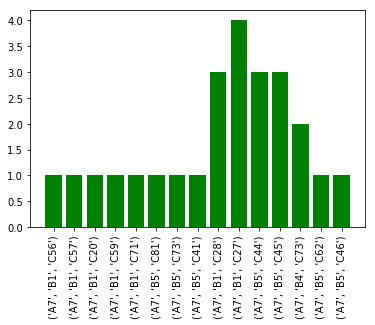

In [102]:
feature_names = generate_feature_names(ictal_data.shape[1])
from collections import defaultdict
feature_usage = defaultdict(int)
for surf in classifiers_v3:
    top_idx = np.argsort(surf.feature_importances_)[-5:]
    for f_idx in top_idx:
        feature_usage[str(feature_names[f_idx])] += 1
        
#print(feature_usage)
plt.bar(list(feature_usage.keys()), feature_usage.values(), color='g')
plt.xticks(rotation='vertical')

In [101]:
# Archive Data
import pickle
def archive_data(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
    
    
archive_data(classifiers_v3, 'surf_v3.pickle')
